In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [3]:
np.random.seed(42)

In [4]:
shift = pd.read_csv('../../datasets/pymc/chemical_shifts_theo_exp.csv')
shift.head()

,ID,aa,theo,exp
0,1BM8,ILE,61.18,58.27
1,1BM8,TYR,56.95,56.18
2,1BM8,SER,56.35,56.84
3,1BM8,ALA,51.96,51.01
4,1BM8,ARG,56.54,54.64


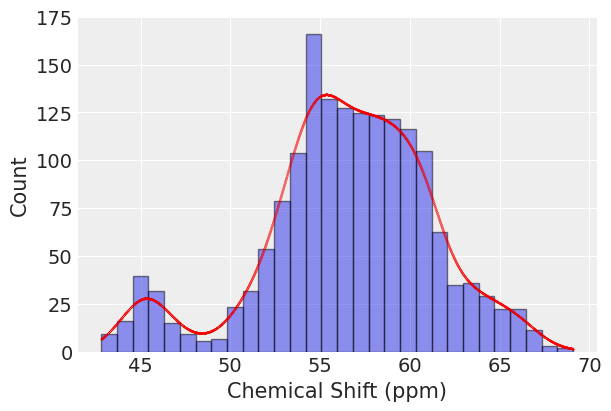

In [5]:
_, ax = plt.subplots(figsize=(6, 4))

x = shift['exp']
kde = stats.gaussian_kde(x)
xx = np.linspace(x.min(), x.max(), 10000)
hist, bin_edges = np.histogram(x, bins=30)

ax.hist(x, bins=30, alpha=0.5, density=True, edgecolor='black',linewidth=1)
ax.plot(xx, kde(xx), 'r.', markersize=0.1)
ax.set(xlabel='Chemical Shift (ppm)', ylabel='Count')

ax.set_yticks(np.linspace(0, ax.get_yticks().max(), 8))
ax.set_yticklabels(np.arange(0, hist.max(), 25));
# plt.savefig('images/ch11/shift.png')

### Dirichlet distribution

In [6]:
from scipy import stats

In [7]:
import mpltern
from mpltern.ternary.datasets import get_shanon_entropies

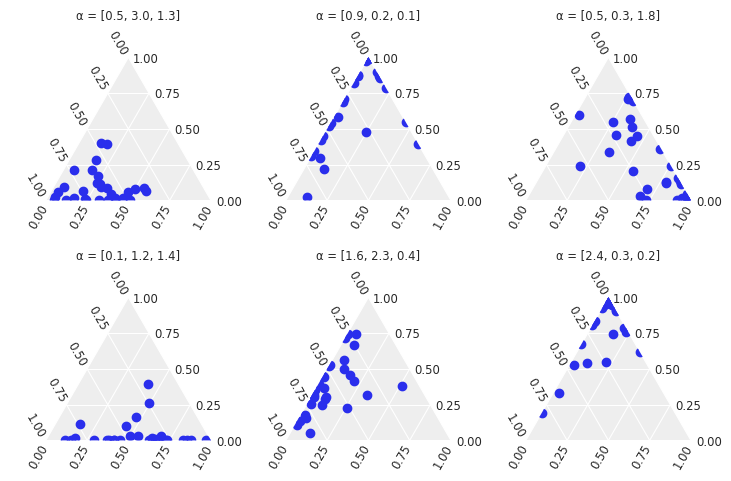

In [8]:
fig = plt.figure()

size = 30

for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1, projection='ternary')
    alphas = stats.expon.rvs(size=size)
    alpha = alphas[:3]
    t, l, r = stats.dirichlet.rvs(alpha, size=size, random_state=42).T
    ax.scatter(t, l, r)
    alpha_show = list(np.round(alpha, 1))
    ax.set_tlabel(f'α = {alpha_show}', fontsize='small')
    ax.tick_params(labelsize='small')

# plt.savefig('images/ch11/dir_dist.png')

In [9]:
cs_exp = shift['exp']
clusters = 2

with pm.Model() as model_kg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    z = pm.Categorical('z', p=p, shape=len(cs_exp))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)

    y = pm.Normal('y', mu=means[z], sd=sd, observed=cs_exp)
    # trace_kg = pm.sample(random_seed=123, return_inferencedata=True)
    # trace_kg.to_netcdf("data/ch11/shift_gk.nc")
    trace_kg = az.from_netcdf("../../datasets/pymc/ch11/shift_gk.nc")

TypeError: RandomVariable.make_node() got an unexpected keyword argument 'sd'

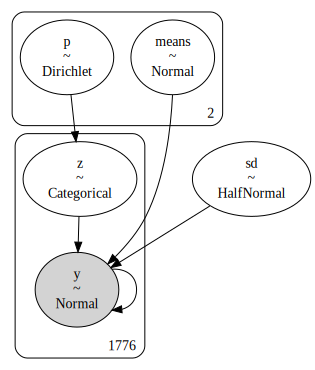

In [ ]:
pm.model_to_graphviz(model_kg)

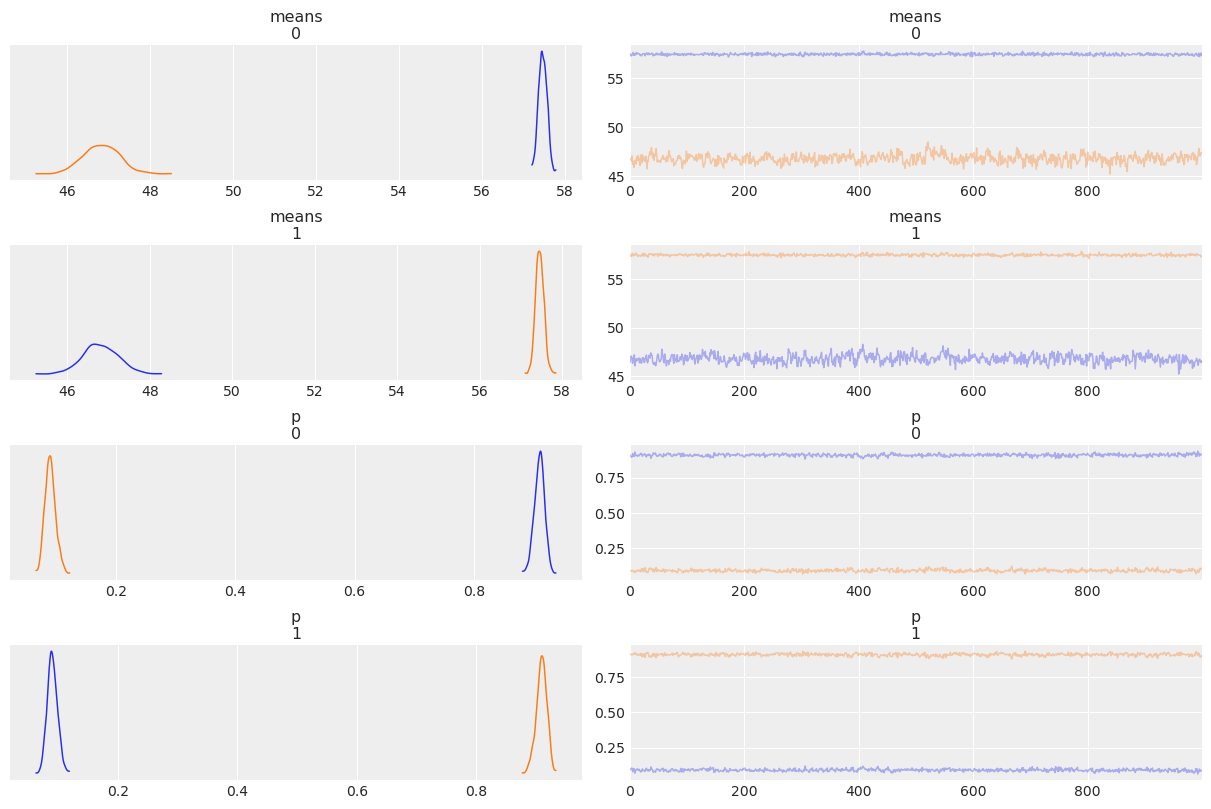

In [ ]:
az.plot_trace(trace_kg, var_names=['means', 'p'], compact=False);

In [ ]:
clusters = 2

cs_exp = shift['exp']

with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    # trace_mg = pm.sample(random_seed=123, return_inferencedata=True)
    # trace_mg.to_netcdf("data/ch11/shift_gm.nc")
    trace_mg = az.from_netcdf("../../datasets/pymc/ch11/shift_gm.nc")

TypeError: dist() missing 1 required positional argument: 'dist_params'

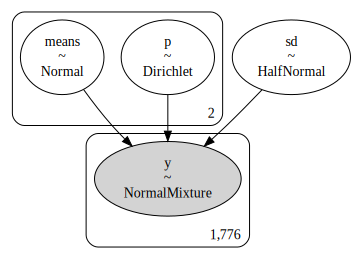

In [ ]:
pm.model_to_graphviz(model_mg)

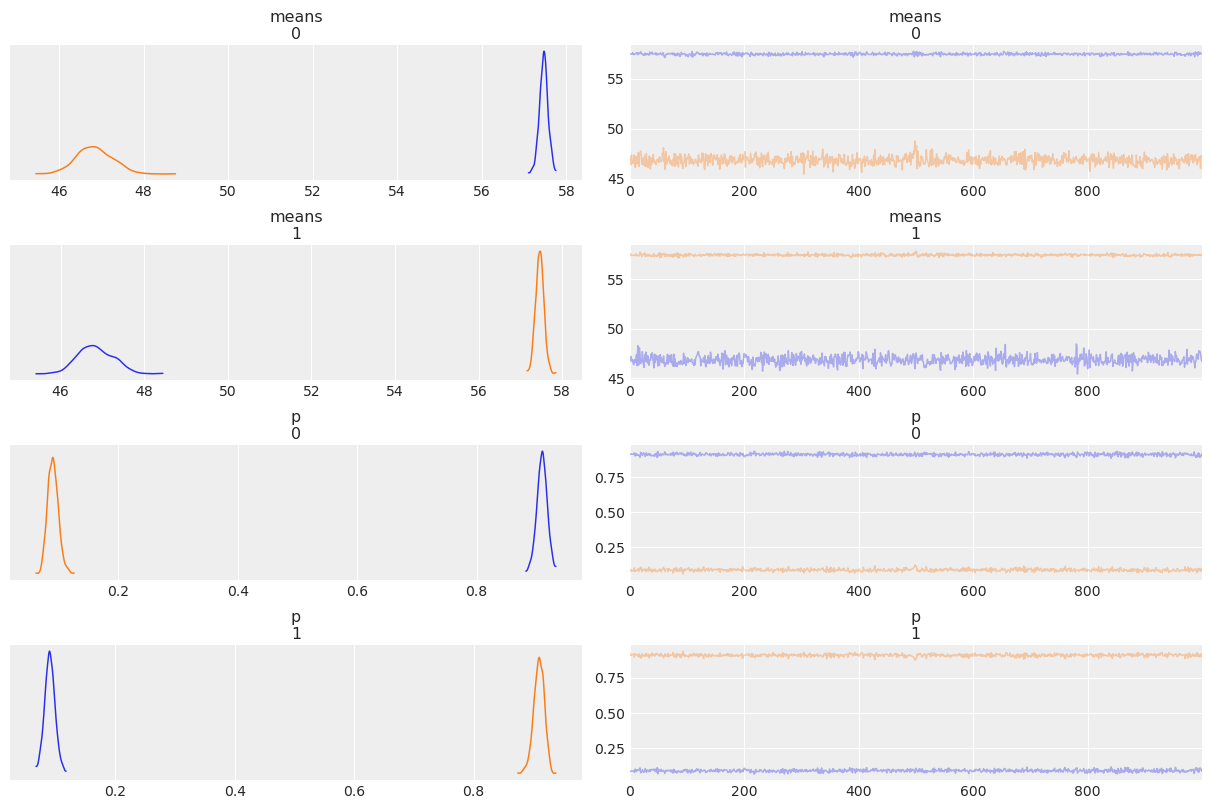

In [ ]:
az.plot_trace(trace_mg, var_names=['means', 'p'], compact=False);
# plt.savefig('images/ch11/dir_trace.png')

In [ ]:
az.summary(trace_mg, var_names=['means', 'p'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],52.154,5.319,46.347,57.672,3.741,3.164,3.0,97.0,1.83
means[1],52.151,5.324,46.302,57.651,3.745,3.167,3.0,89.0,1.83
p[0],0.500,0.410,0.076,0.922,0.289,0.244,3.0,67.0,1.83
p[1],0.500,0.410,0.078,0.924,0.289,0.244,3.0,67.0,1.83


## Non-identifiability of mixture models

In [ ]:
import theano.tensor as tt

In [ ]:
clusters = 2

with pm.Model() as model_mgp:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means',
                      mu=np.array([.9, 1]) * cs_exp.mean(),
                      sd=10,
                      shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    order_means = pm.Potential('order_means',
                               tt.switch(means[1] - means[0] < 0, -np.inf, 0))
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    # trace_mgp = pm.sample(1000, random_seed=123, return_inferencedata=True)
    # trace_mgp.to_netcdf("data/ch11/shift_gmn.nc")
    trace_mgp = az.from_netcdf("../../datasets/pymc/ch11/shift_gmn.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.


In [ ]:
# instead of a potential we can use an ordered transformation
# transform=pm.distributions.transforms.ordered

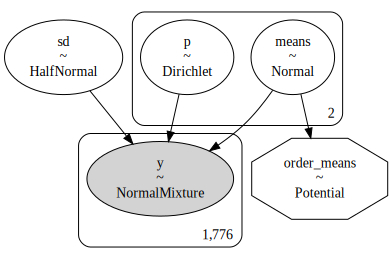

In [ ]:
pm.model_to_graphviz(model_mgp)

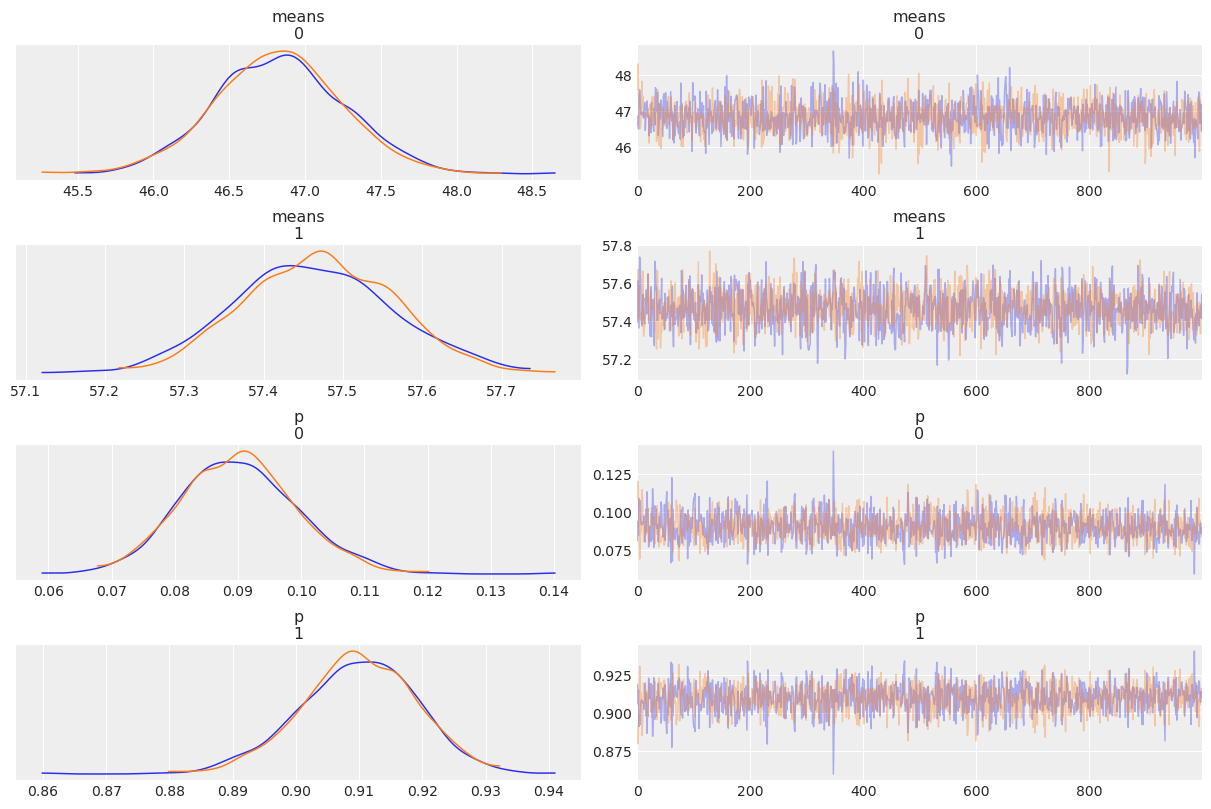

In [ ]:
az.plot_trace(trace_mgp, var_names=['means', 'p'], compact=False);

In [ ]:
az.summary(trace_mgp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],46.828,0.424,46.007,47.597,0.009,0.007,2049.0,1583.0,1.0
means[1],57.466,0.097,57.302,57.667,0.002,0.002,1913.0,1414.0,1.0
p[0],0.090,0.009,0.073,0.108,0.000,0.000,1848.0,1651.0,1.0
p[1],0.910,0.009,0.892,0.927,0.000,0.000,1848.0,1651.0,1.0
sd,3.649,0.073,3.514,3.781,0.002,0.001,1925.0,1305.0,1.0


## How to choose K

In [ ]:
clusters = [3, 4, 5, 6]

models = []
traces = []

for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(cluster))
        means = pm.Normal('means',
                          mu=np.linspace(cs_exp.min(), cs_exp.max(), cluster),
                          sd=10,
                          shape=cluster,
                          transform=pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd=10)
        y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
        # trace = pm.sample(1000,
        #                   tune=2000,
        #                   random_seed=123,
        #                   return_inferencedata=True)
        # trace.to_netcdf(f"data/ch11/shift_gmk_{cluster}.nc")
        trace = az.from_netcdf(f"data/ch11/shift_gmk_{clusterf}.nc")
        traces.append(trace)
        models.append(model)

TypeError: dist() missing 1 required positional argument: 'dist_params'

In [ ]:
trace_x.posterior['p'].shape

(2, 1000, 3)

In [ ]:
trace_x.posterior['means'].shape

(2, 1000, 3)

In [ ]:
trace_x.posterior['sd'].shape

(2, 1000)

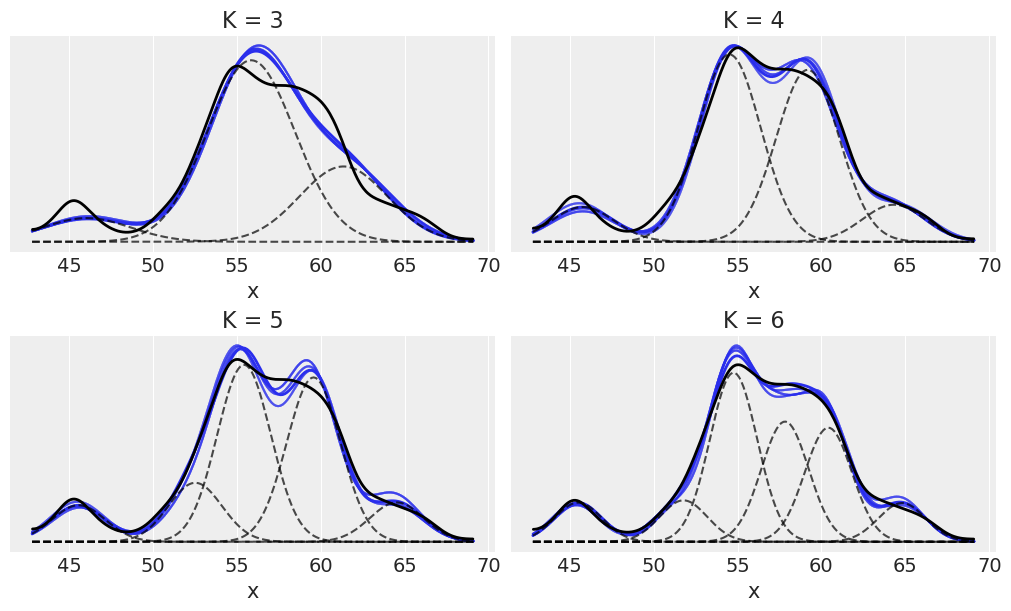

In [ ]:
_, axes = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)

x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
clusters = [3, 4, 5, 6]

for trace_x, ax, cluster in zip(traces, axes.flatten(), clusters):
    x_ = np.array([x] * cluster).T

    for i in range(50):
        i_ = np.random.randint(0, len(trace_x.posterior))
        p_y = trace_x.posterior['p'].mean(axis=0)[i_].values
        means_y = trace_x.posterior['means'].mean(axis=0)[i_].values
        sd = trace_x.posterior['sd'].mean(axis=0)[i_].values
        dist = stats.norm(means_y, sd)
        ax.plot(x, np.sum(dist.pdf(x_) * p_y, axis=1), 'C0', alpha=0.1)

    p_y = trace_x.posterior['p'].mean(axis=0).mean(axis=0).values
    means_y = trace_x.posterior['means'].mean(axis=0).mean(axis=0).values
    sd = trace_x.posterior['sd'].mean(axis=0).mean().values
    dist = stats.norm(means_y, sd)
    ax.plot(x, np.sum(dist.pdf(x_) * p_y, axis=1), 'C0', lw=2)
    ax.plot(x, dist.pdf(x_) * p_y, 'k--', alpha=0.7)

    az.plot_kde(cs_exp, plot_kwargs={'lw': 2, 'color': 'k'}, ax=ax)
    ax.set(title=f'K = {cluster}', xlabel='x', yticks=[])

# plt.savefig('images/ch11/choosing_k.png')

In [ ]:
ppc_mm = []

for i in range(4):
    # ppc = pm.sample_posterior_predictive(traces[i], 1000, models[i])
    # with models[i]:
    #     ppc_m = az.from_dict(ppc_mm[i])
    #     ppc_m.to_netcdf(f'data/ch11/k_ppc_{i}.nc')
    ppc_mm.append(az.from_netcdf(f'data/ch11/k_ppc_{i}.nc').posterior['y'])

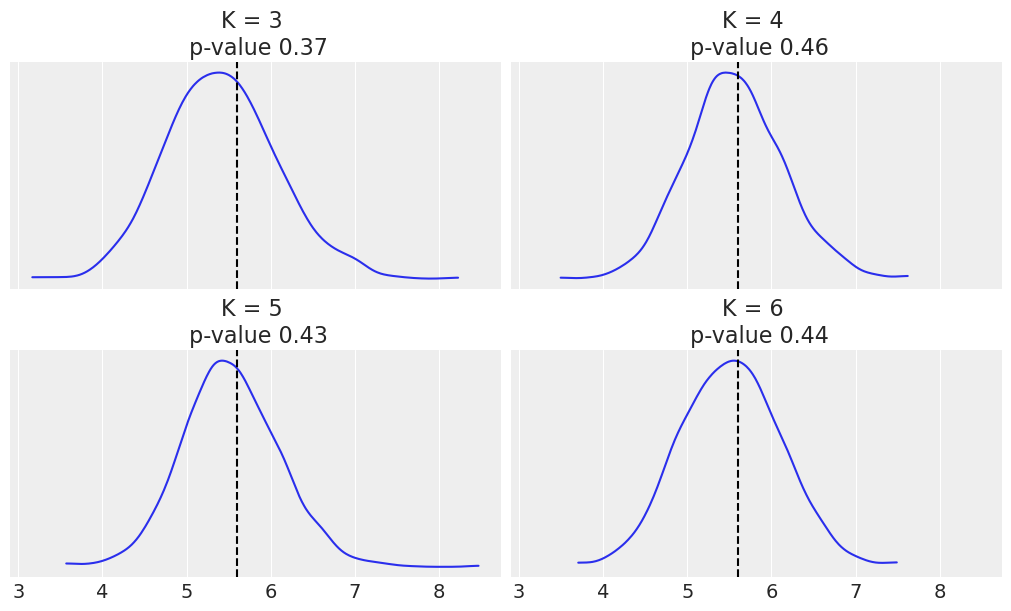

In [ ]:
fig, axes = plt.subplots(2,
                         2,
                         figsize=(10, 6),
                         sharex=True,
                         constrained_layout=True)


def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))


T_obs = iqr(cs_exp)

for d_sim, ax, cluster in zip(ppc_mm, axes.flatten(), clusters):
    T_sim = iqr(d_sim[:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax)
    ax.axvline(T_obs, 0, 1, color='k', ls='--')
    ax.set(title=f'K = {cluster} \n p-value {p_value:.2f}', yticks=[])

# plt.savefig('images/ch11/choosing_k_ppc.png')

In [ ]:
comp = az.compare(dict(zip(clusters, traces)),
                  ic='waic',
                  scale='deviance',
                  method='BB-pseudo-BMA')
comp

/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
6,0,10248.426509,11.958802,0.000000,9.548160e-01,61.008086,0.000000,False,deviance
5,1,10258.884051,10.100865,10.457541,4.399500e-02,60.653137,4.985508,False,deviance
4,2,10278.929944,7.521739,30.503435,1.188968e-03,59.517198,9.958262,False,deviance
3,3,10356.819488,5.854708,108.392978,1.257345e-14,59.692142,18.666879,False,deviance


In [ ]:
comp.to_markdown()

'|    |   rank |    waic |   p_waic |   d_waic |      weight |      se |      dse | warning   | waic_scale   |\n|---:|-------:|--------:|---------:|---------:|------------:|--------:|---------:|:----------|:-------------|\n|  6 |      0 | 10248.4 | 11.9588  |   0      | 0.954816    | 61.0081 |  0       | False     | deviance     |\n|  5 |      1 | 10258.9 | 10.1009  |  10.4575 | 0.043995    | 60.6531 |  4.98551 | False     | deviance     |\n|  4 |      2 | 10278.9 |  7.52174 |  30.5034 | 0.00118897  | 59.5172 |  9.95826 | False     | deviance     |\n|  3 |      3 | 10356.8 |  5.85471 | 108.393  | 1.25734e-14 | 59.6921 | 18.6669  | False     | deviance     |'

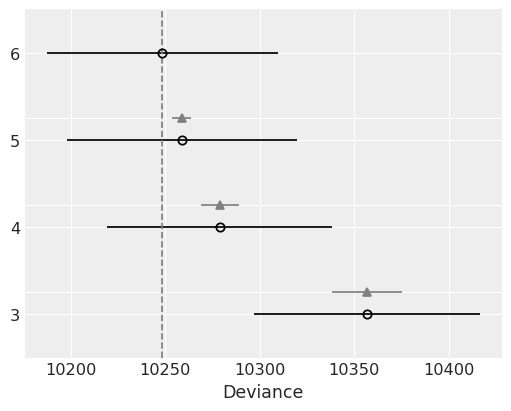

In [ ]:
_, ax = plt.subplots(figsize=(5, 4))

az.plot_compare(comp, insample_dev=False, ax=ax)
# plt.savefig('images/ch11/choosing_k_comp.png')

## Non-finite mixture model

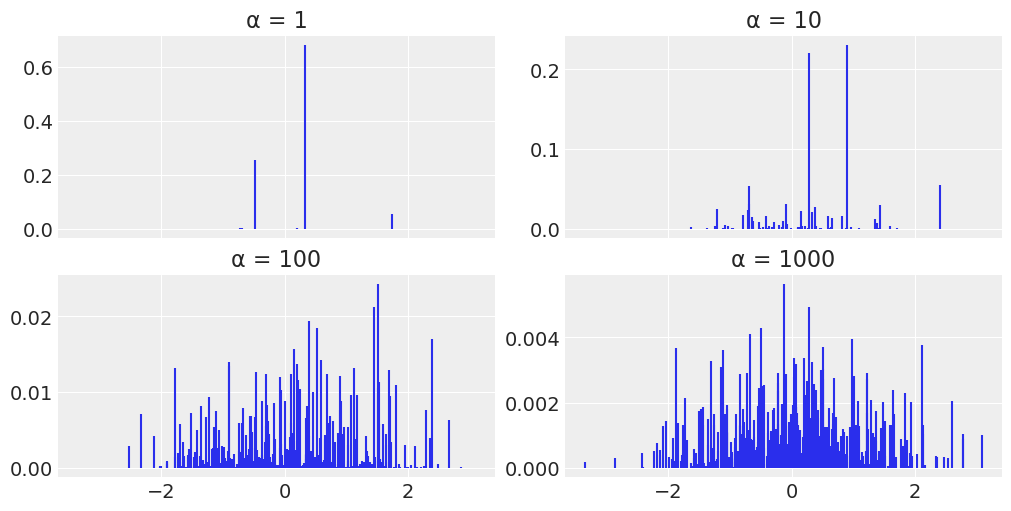

In [ ]:
def stick_breaking_truncated(α, H, K):
    """
    Truncated stick-breaking process view of a DP
    
    Parameters
    ----------
    α : concentration parameter
    H : Base distribution
    K : number of components
    
    Returns
    -------
    locs : locations
    w : probabilities
    """
    βs = stats.beta.rvs(1, α, size=K)
    w = np.empty(K)
    w = βs * np.concatenate(([1.], np.cumprod(1 - βs[:-1])))
    locs = H.rvs(size=K)
    return locs, w


# Parameters DP
K = 500
H = stats.norm
alphas = [1, 10, 100, 1000]

# plot
_, axes = plt.subplots(2,
                       2,
                       sharex=True,
                       figsize=(10, 5),
                       constrained_layout=True)

for α, ax in zip(alphas, axes.flatten()):
    locs, w = stick_breaking_truncated(α, H, K)
    ax.vlines(locs, 0, w, color='C0')
    ax.set(title=f'α = {α}')

# plt.savefig('images/ch11/stick.png')

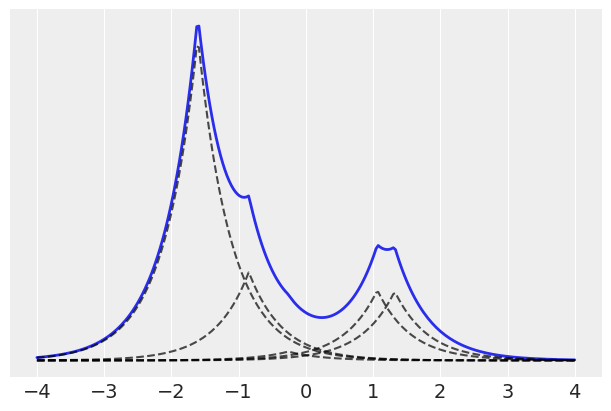

In [ ]:
α = 10
H = stats.norm
K = 5

x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T

locs, w = stick_breaking_truncated(α, H, K)
dist = stats.laplace(locs, 0.5)

_, ax = plt.subplots(figsize=(6, 4))

ax.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
ax.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
ax.set(yticks=[])
# plt.savefig('images/ch11/lapmm.png')

In [ ]:
K = 20

def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [ ]:
with pm.Model() as model:
    α = pm.Gamma('α', 1, 1.)
    w = pm.Deterministic('w', stick_breaking(α, K))
    means = pm.Normal('means',
                      mu=np.linspace(cs_exp.min(), cs_exp.max(), K),
                      sd=10,
                      shape=K)

    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=cs_exp.values)
    # trace_inf = pm.sample(1000,
    #                       tune=2000,
    #                       target_accept = 0.85,
    #                       return_inferencedata=True)
    # trace_inf.to_netcdf("data/ch11/shift_gminf.nc")
    trace_inf = az.from_netcdf("../../datasets/pymc/ch11/shift_gminf.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, β, α]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 721 seconds.
There were 256 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.756934925515149, but should be close to 0.85. Try to increase the number of tuning steps.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7479098432057062, but should be close to 0.85. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


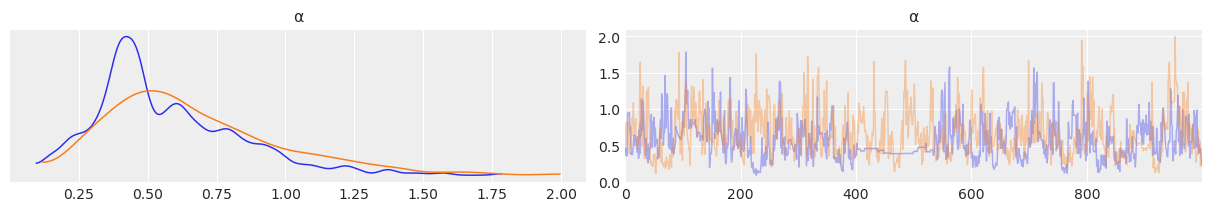

In [ ]:
az.plot_trace(trace_inf, var_names=['α'], divergences=False, compact=False);
# plt.savefig('images/ch11/stick_trace.png')

In [ ]:
w = trace_inf.posterior['w'].mean(axis=0)
means = trace_inf.posterior['means'].mean(axis=0)
sd = trace_inf.posterior['sd'].mean(axis=0)

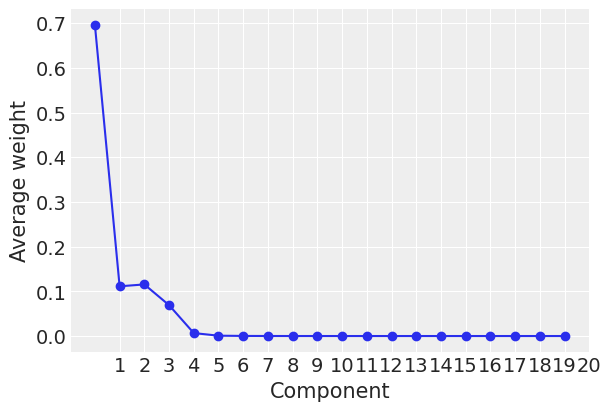

In [ ]:
_, ax = plt.subplots(figsize=(6, 4))

plot_w = np.arange(K)

ax.plot(plot_w, w.mean(axis=0), 'o-')
ax.set(xticks=(plot_w + 1), xlabel='Component', ylabel='Average weight')
# plt.savefig('images/ch11/stick_k.png')

In [ ]:
x_plot = np.linspace(cs['exp'].min() - 1, cs['exp'].max() + 1, 200)

post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
                                   means.values[:, np.newaxis, :],
                                   sd.values[:, np.newaxis, :])
post_pdfs = (w.values[:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

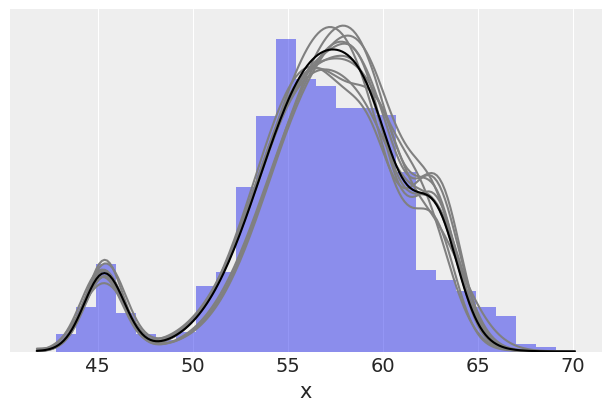

In [ ]:
_, ax = plt.subplots(figsize=(6, 4))

ax.hist(cs_exp.values, bins=25, density=True, alpha=0.5)
ax.plot(x_plot, post_pdfs[::100].T, c='0.5')
ax.plot(x_plot, post_pdfs.mean(axis=0), c='k')

ax.set(xlabel='x', yticks=[])
# plt.savefig('images/ch11/stick_kde.png')